In [1]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

import rioxarray

### exersice 1:Open vector data with GeoDataFrame and plot it.

In [2]:
gadm_files = [os.path.join(root, file)
              for root, dirs, files in os.walk("_data/gadm/")
              for file in files if file.startswith("gadm")]

print(gadm_files)

# Select regional level 2 files
gadm_files_level2 = [file for file in gadm_files if "2.shp" in file]
#print(gadm_files_level2)

# Load the shapefiles
shps = [gpd.read_file(shp) for shp in gadm_files_level2]
#print(shps)

['_data/gadm/gadm41_DEU_1.prj', '_data/gadm/gadm41_DEU_0.prj', '_data/gadm/gadm41_DEU_2.prj', '_data/gadm/gadm41_DEU_3.prj', '_data/gadm/gadm41_DEU_4.prj', '_data/gadm/gadm41_DEU_4.dbf', '_data/gadm/gadm41_DEU_3.dbf', '_data/gadm/gadm41_DEU_2.dbf', '_data/gadm/gadm41_DEU_0.dbf', '_data/gadm/gadm41_DEU_1.dbf', '_data/gadm/gadm41_DEU_1.cpg', '_data/gadm/gadm41_DEU_1.shp', '_data/gadm/gadm41_DEU_2.shx', '_data/gadm/gadm41_DEU_3.shx', '_data/gadm/gadm41_DEU_0.shp', '_data/gadm/gadm41_DEU_0.cpg', '_data/gadm/gadm41_DEU_2.cpg', '_data/gadm/gadm41_DEU_2.shp', '_data/gadm/gadm41_DEU_1.shx', '_data/gadm/gadm41_DEU_0.shx', '_data/gadm/gadm41_DEU_3.shp', '_data/gadm/gadm41_DEU_3.cpg', '_data/gadm/gadm41_DEU_4.shx', '_data/gadm/gadm41_DEU_4.cpg', '_data/gadm/gadm41_DEU_4.shp']


<Axes: >

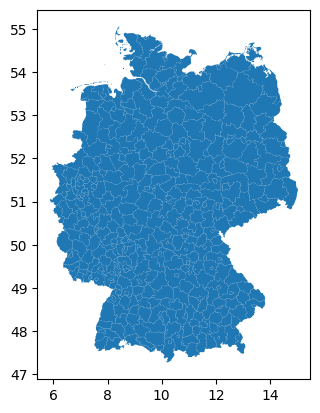

In [3]:
germany_shp = gpd.GeoDataFrame(pd.concat(shps, ignore_index=True))
germany_shp.plot()

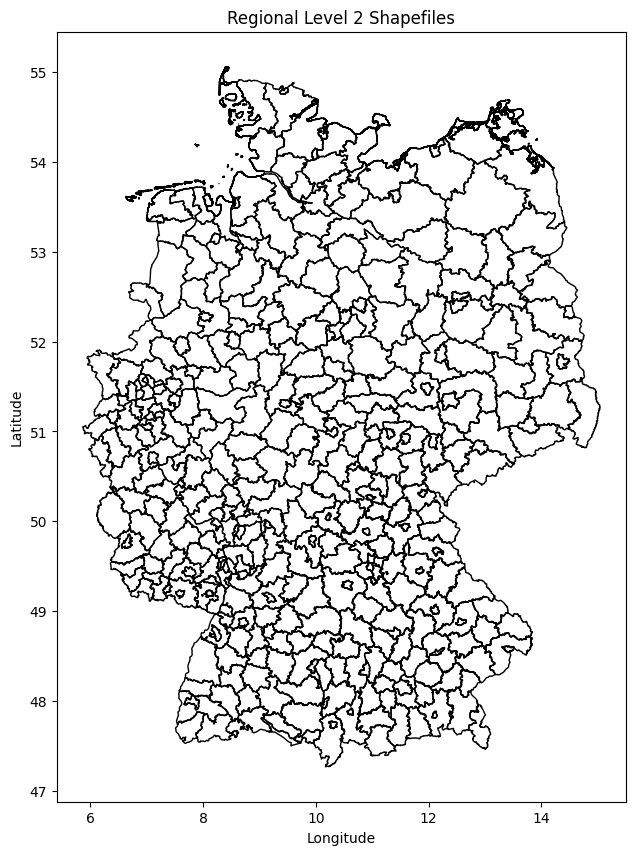

In [4]:
fig, ax = plt.subplots(figsize=(10, 10))

germany_shp.plot(ax=ax, edgecolor='k', facecolor='none', linewidth=1)  # No fill color


# Set plot title and labels
ax.set_title('Regional Level 2 Shapefiles')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show plot
plt.show()

In [5]:
print(germany_shp.geom_type.unique())


['Polygon' 'MultiPolygon']


### exersice 2: Open raster data with rioxarray and plot it. See if it works and doesn’t crash.

In [6]:
raster_path = "_data/F152008.tif"

raster = rioxarray.open_rasterio(raster_path, chunks=True)  # головне — chunks=True
print(raster) #pf

<xarray.DataArray (band: 1, y: 16801, x: 43201)> Size: 726MB
dask.array<open_rasterio-6e0d9447d1634668484f79e92d4cb20d<this-array>, shape=(1, 16801, 43201), dtype=uint8, chunksize=(1, 3106, 43201), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 134kB 75.0 74.99 74.98 ... -64.98 -64.99 -65.0
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:  100
    TIFFTAG_YRESOLUTION:  100
    AREA_OR_POINT:        Area
    scale_factor:         1.0
    add_offset:           0.0


Завантажую через даск ліниво тому не крашиться, все ок

In [ ]:
raster.plot(figsize=(10, 8))
plt.title("Nighttime Lights (F152008)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

але зоображатись не хоче

### Exercise 3: Try reducing the size of raster data by factor of 10. How would you do it?

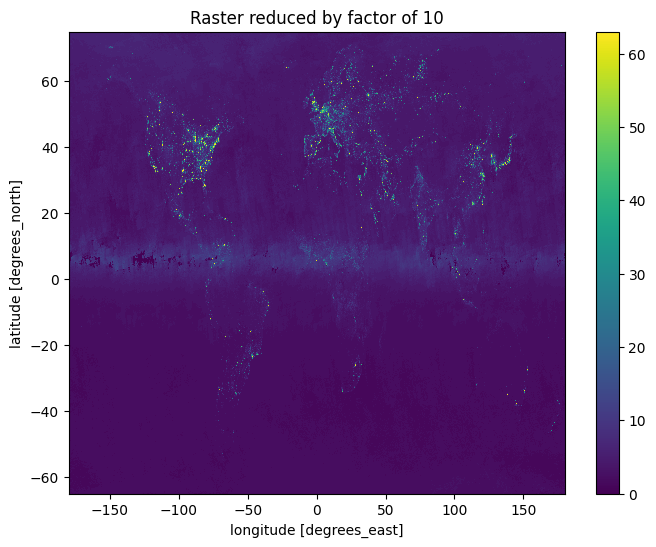

/Users/lidaharyton/analytics/.venv/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/lidaharyton/analytics/.venv/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/lidaharyton/analytics/.venv/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/Users/lidaharyton/analytics/.venv/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


In [7]:
from rasterio.enums import Resampling

raster_small = raster.rio.reproject(
    raster.rio.crs,
    shape=(raster.sizes['y'] // 10, raster.sizes['x'] // 10),
    resampling=Resampling.average
)

raster_small.plot(figsize=(8, 6))
plt.title("Raster reduced by factor of 10")
plt.show()


shape=() задає нову кількість пікселів — у 10 разів меншу по обох осях.

Resampling.average допомагає згладити дані, щоб при зменшенні не втратити яскравість і не було піксилізації.

.rio.reproject() виконує ресемплінг у тому ж CRS.

### Exercise 4:Clip/mask raster data so that it fits the vector geometry of your country’s vector data. Plot it.

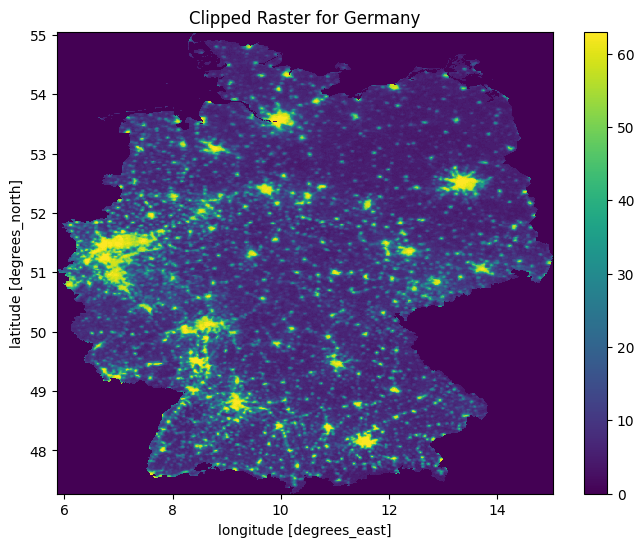

In [8]:
raster_clipped = raster.rio.clip(germany_shp.geometry, germany_shp.crs, drop=True, invert=False)
raster_clipped.plot(figsize=(8, 6))
plt.title("Clipped Raster for Germany")
plt.show()

### Exercise 5: Compute average luminosity for each level 2 region.

In [9]:
from rasterstats import zonal_stats

temp_raster = "_data/temp_clipped_raster.tif"
raster_clipped.rio.to_raster(temp_raster)

stats = zonal_stats(germany_shp, temp_raster, stats=["mean"], nodata=0)

germany_shp["mean_radiance"] = [s["mean"] for s in stats]

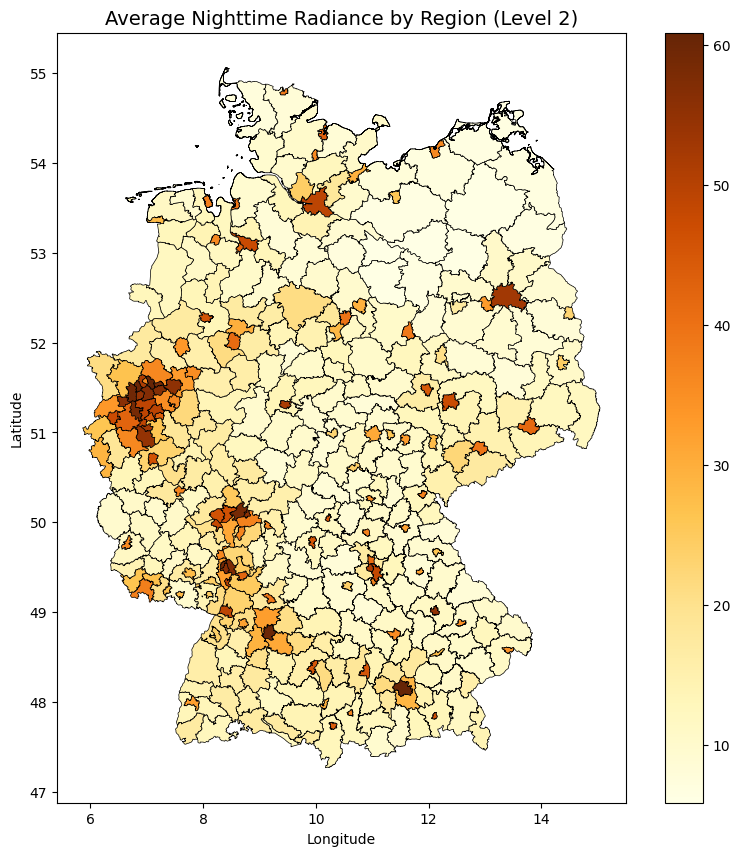

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

germany_shp.plot(
    column="mean_radiance",  
    cmap="YlOrBr",           
    legend=True,
    edgecolor="black", linewidth=0.5,
    ax=ax
)

ax.set_title("Average Nighttime Radiance by Region (Level 2)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()


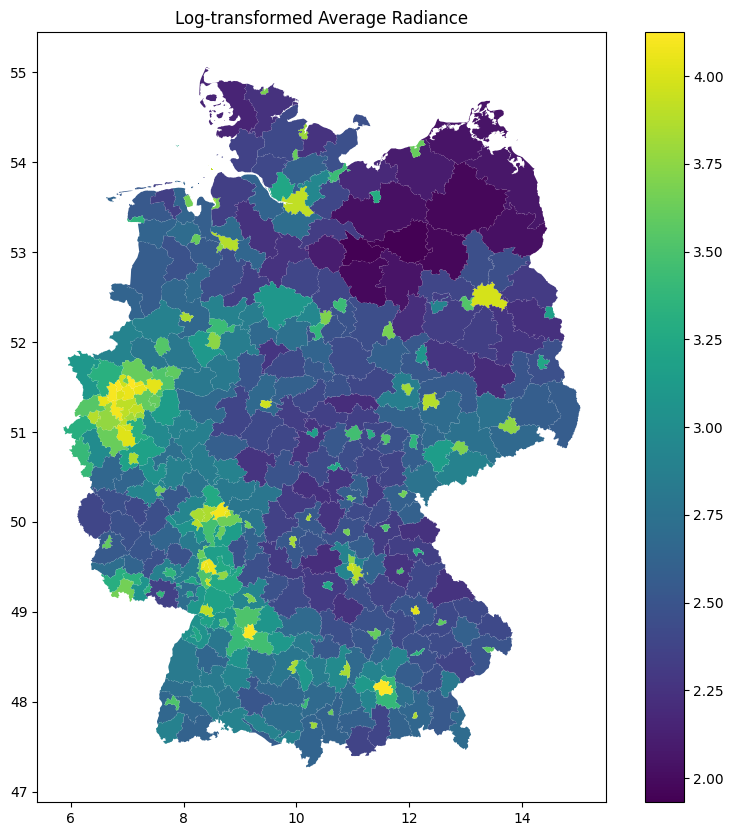

In [11]:
import numpy as np

germany_shp["log_radiance"] = np.log1p(germany_shp["mean_radiance"])

germany_shp.plot(column="log_radiance", cmap="viridis", legend=True, figsize=(10, 10))
plt.title("Log-transformed Average Radiance")
plt.show()


### Exercise 6 : Create a resulting GeoDataFrame with additional column showing the difference in average luminosity between start_month and end_month, and save it to a file. Ah, and don’t forget to plot it.

In [16]:
raster_path2 = "_data/F162009.tif"

raster2 = rioxarray.open_rasterio(raster_path2, chunks=True)
print(raster2)

<xarray.DataArray (band: 1, y: 16801, x: 43201)> Size: 726MB
dask.array<open_rasterio-e8a84cff272c7b0726aabae3cd837a32<this-array>, shape=(1, 16801, 43201), dtype=uint8, chunksize=(1, 3106, 43201), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 134kB 75.0 74.99 74.98 ... -64.98 -64.99 -65.0
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:  1
    TIFFTAG_YRESOLUTION:  1
    AREA_OR_POINT:        Area
    scale_factor:         1.0
    add_offset:           0.0


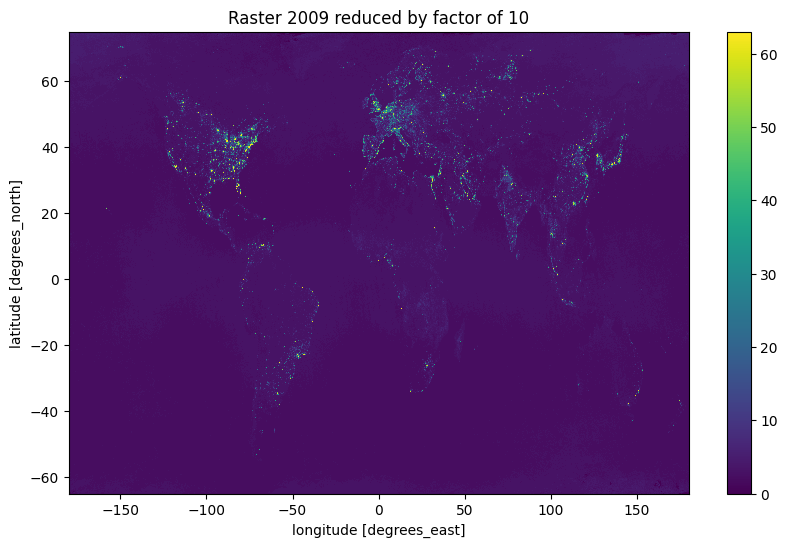

In [18]:
raster2_small = raster2.rio.reproject(
    raster2.rio.crs,
    shape=(raster2.sizes['y'] // 10, raster2.sizes['x'] // 10),
    resampling=Resampling.average
)

raster2_small.plot(figsize=(10,6))
plt.title("Raster 2009 reduced by factor of 10")
plt.show()

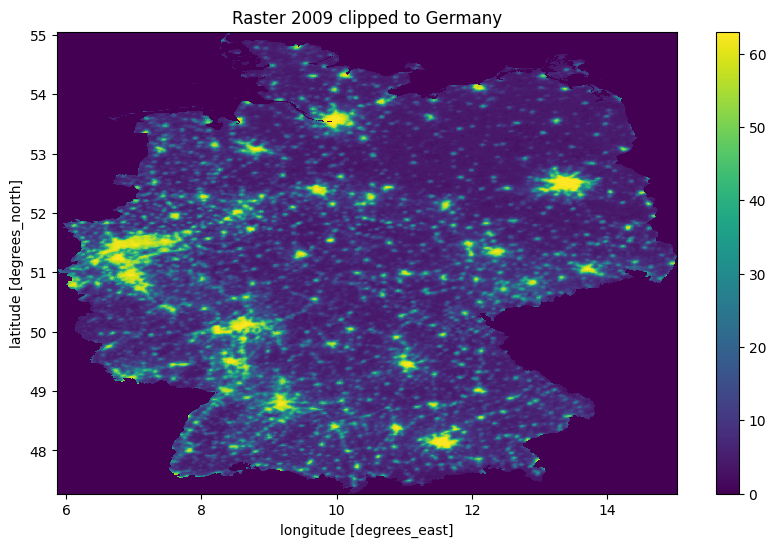

In [20]:
raster2_clipped = raster2.rio.clip(germany_shp.geometry, germany_shp.crs, drop=True, invert=False)
raster2_clipped.plot(figsize=(10,6))
plt.title("Raster 2009 clipped to Germany")
plt.show()

In [21]:
temp_raster2 = "_data/temp_clipped_raster2.tif"
raster2_clipped.rio.to_raster(temp_raster2)

stats2 = zonal_stats(germany_shp, temp_raster2, stats=["mean"], nodata=0)
germany_shp["mean_radiance_2"] = [s["mean"] for s in stats2]


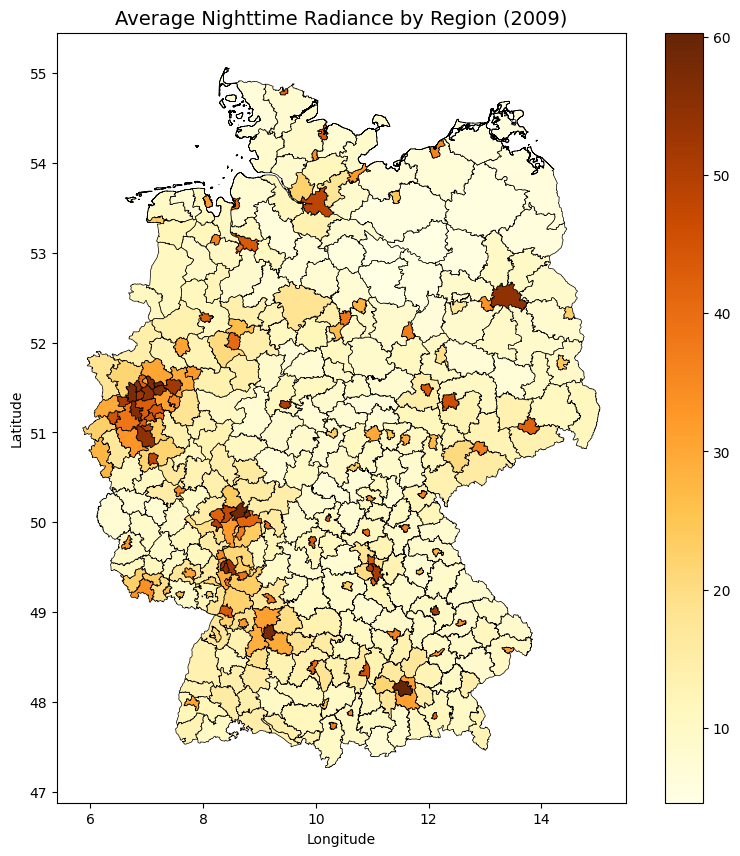

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

germany_shp.plot(
    column="mean_radiance_2",
    cmap="YlOrBr", 
    legend=True, 
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)

ax.set_title("Average Nighttime Radiance by Region (2009)", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

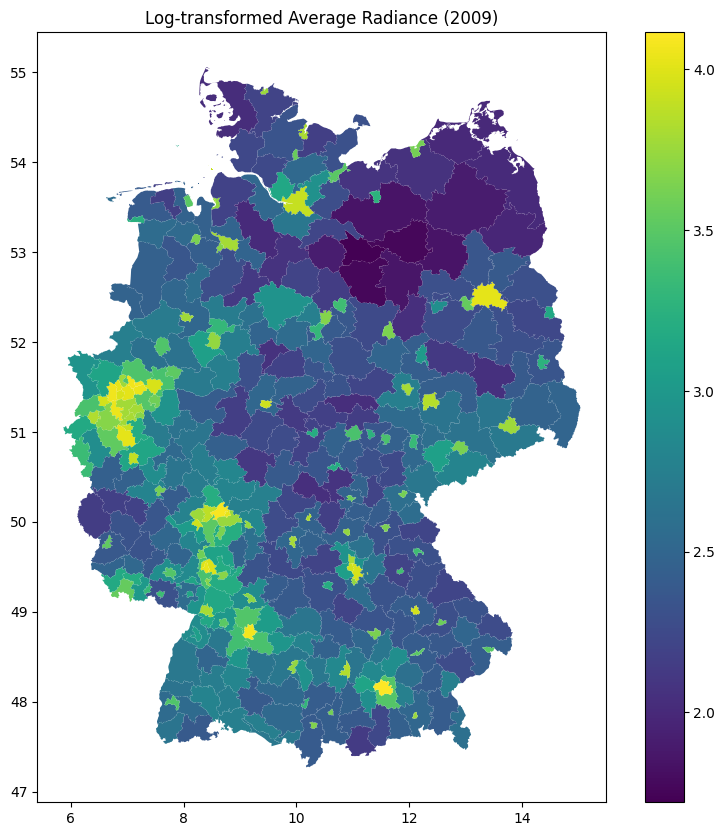

In [23]:
germany_shp["log_radiance_2"] = np.log1p(germany_shp["mean_radiance_2"])

germany_shp.plot(column="log_radiance_2", cmap="viridis", legend=True, figsize=(10, 10))
plt.title("Log-transformed Average Radiance (2009)")
plt.show()

# Порівнюєм

Text(292.04186862376326, 0.5, 'Latitude')

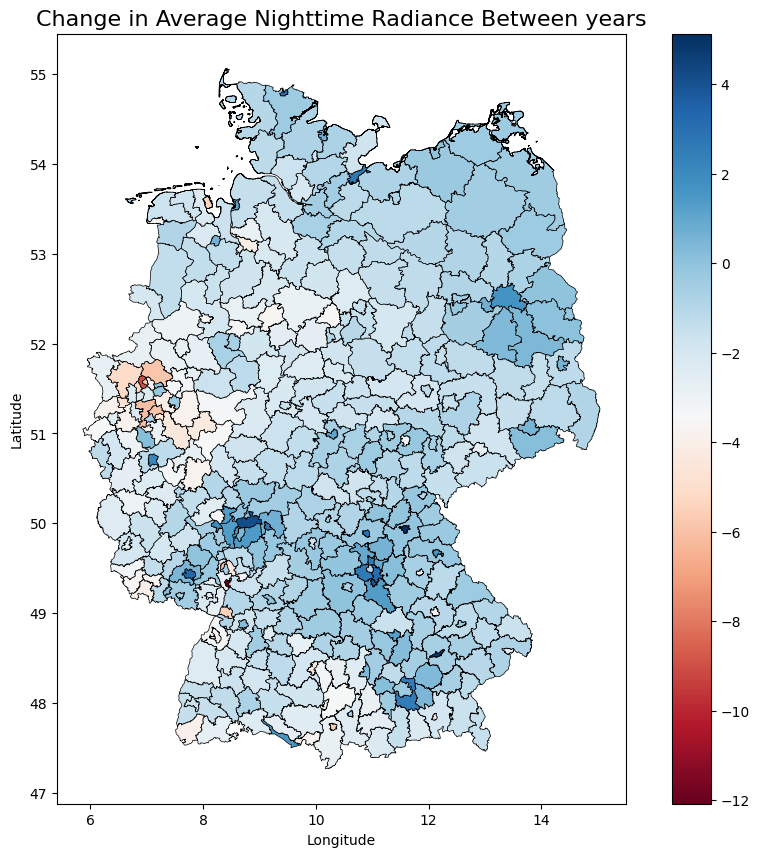

In [26]:
germany_shp["diff_radiance"] = germany_shp["mean_radiance_2"] - germany_shp["mean_radiance"]

output_file = "_data/germany_radiance_diff.geojson"#зберігаємо
germany_shp.to_file(output_file, driver="GeoJSON")



fig, ax = plt.subplots(figsize=(12, 10))
germany_shp.plot(
    column="diff_radiance",
    cmap="RdBu",            # синє = зменшення, червоне = зростання
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)
ax.set_title("Change in Average Nighttime Radiance Between years", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")